# Playing Card Data

In the user study, we chose to use playing card data for several reasons:
- We expected most participants to be **familiar** with them.
- They have **intrinsic variation** according to several features: colors (Red or Black), suits (Hearts, Spades, Clubs and Diamonds), numbers and figures. Thus, it is easy to control the difficulty of the teaching task by choosing a sub-set of the deck. For example, we expect that the binary classification between queen and king is harder than between ace and king.
- It makes our user study more **reproducible** than using other objects that one might not find easily.

During the teaching session of the user study, participants are asked to classifify four classes: the *aces*, the *nines*, the *queens* and the *kings*. We provide them extra cards, the *jacks*, the *twos* and the *tens* and to be able to try out outliers.


## Data collection

We collected 600 playing card images with a camera mounted on a stand shown on the following figure:

<img src="./images/setup.jpg" width=250 height=250 />







We only used the cards participants will have access to. It includes:
- 150 training images of the four training classes (ace, nine, queen, king),
- 150 testing images of the four training classes (ace, nine, queen, king),
- 50 uncertain images including outliers, superpositions of multiple cards.

The data was processed using a script available in `src/utilities.py` file. The processed images are stored in a pickle file accessible online. The following cells download and import the data into the notebook.

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
import numpy as np

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
from common.utilities import Data, Annotator
from common.figures import Figures

import matplotlib
font = {'family' : 'Times',
        'size'   : 22}

matplotlib.rc('font', **font)
from matplotlib import rc

rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
filepath = "./datasets/consistent_card_data.pkl"
train, test, uncertain = Data.get_dataset(filepath = filepath)
(z_train, y_train), (z_test, y_test), z_uncertain = Data.dataframe2arrays(train, test, uncertain)

Dataset loaded...
Number of images:  350
Features:  name, class_label, uncertainty_label, group, X_PIL, X_array, X_mobilenet, y_onehot, y, z_ensemble
Labels:  king, nine, queen
Training set size:  150
Testing set size:  150
Uncertain pool size:  50


Let's have a look to the training, testing and uncertain data.

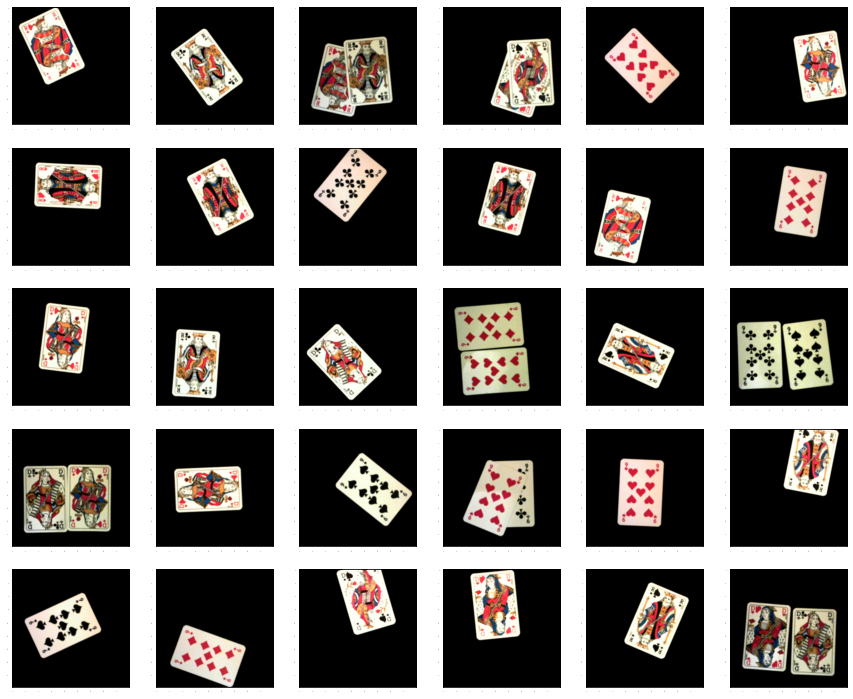

In [6]:
# Train data
X_train = np.array([tf.keras.preprocessing.image.img_to_array(img)/255.0 for img in train["X_PIL"].values])
Figures.image_grid(X_train[np.random.choice(X_train.shape[0], 30, replace = False)], 6)

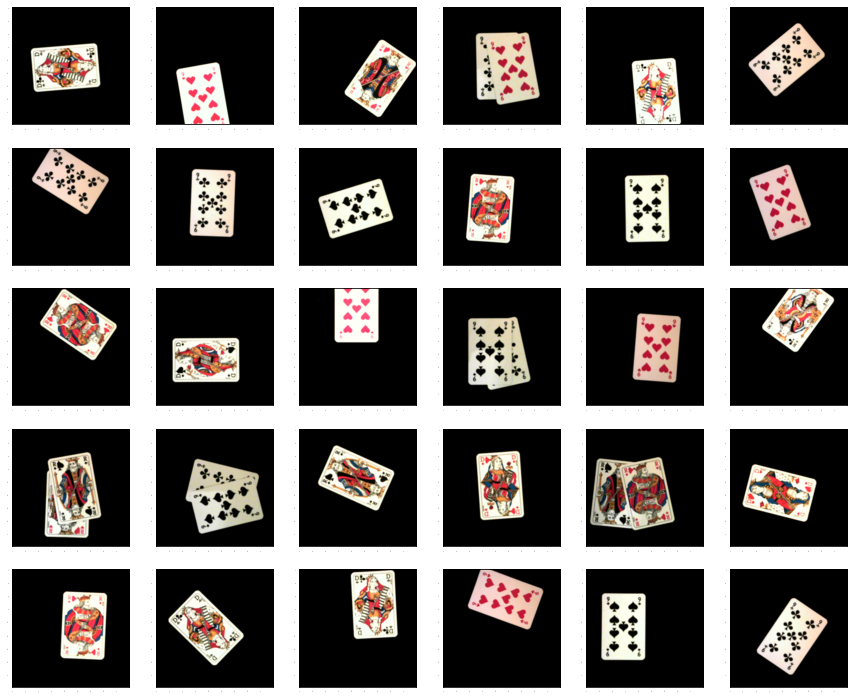

In [51]:
# Testing data
X_test = np.array([tf.keras.preprocessing.image.img_to_array(img)/255.0 for img in test["X_PIL"].values])
Figures.image_grid(X_test[np.random.choice(X_test.shape[0], 30, replace = False)], 6)

In [ ]:
X_uncertain_ = [tf.keras.preprocessing.image.img_to_array(img) for img in uncertain['X_PIL'].values]
fig = Figures.image_grid(X_uncertain_[:9], 3)
fig.savefig("CARDS_uncertain.pdf", bbox_inches='tight')

## Data annotation

The main author annotated each image with a label about the perceived uncertainty:
- "Classifiable" if the image can be classified as belonging to the four training class (ace, nine, queen and king),
- "Novel" if the image cannot be classified because the image is new regarding what the classifier should know,
- "Ambiguous" if the image cannot be classified because it is too ambiguous regarding the four training class,
- "I don't know" none of the previous apply.

We used a labeling tool in the jupyter notebook as follow:

In [52]:
annotations = Annotator(uncertain).start()
annotations

Output(layout=Layout(border='1px solid black'))

We also label the training and test data as "Classifiable"

In [ ]:
import pickle
new_dataset = pd.concat((train, test, uncertain), axis = 0)
train["uncertainty_label"] = "Classifiable"
test["uncertainty_label"] = "Classifiable"
pickle.dump(new_dataset, open('/Users/teosanchez/Recherche/Uncertainty-IUI2022/uncertainty-IUI-2022-benchmark_branch/benchmark/datasets/processed_data/consistent_card_data.pkl', 'wb'))

## Data analysis in the feature space

To speed up the training and enable interactive and incremental training during the user study, we had to perform transfer learning. To do so, we investigated embeddings that transform our data into a feature space.

We investigate four different embeedings:
- MobileNetV1,
- MobileNetV2,
- ResNet50,
- The combination of MobileNetV1, MobileNetV2 and ResNet50

To better estimate the richness and the variance distribution within our four feature spaces, we perform Principal Component Analysis (PCA).

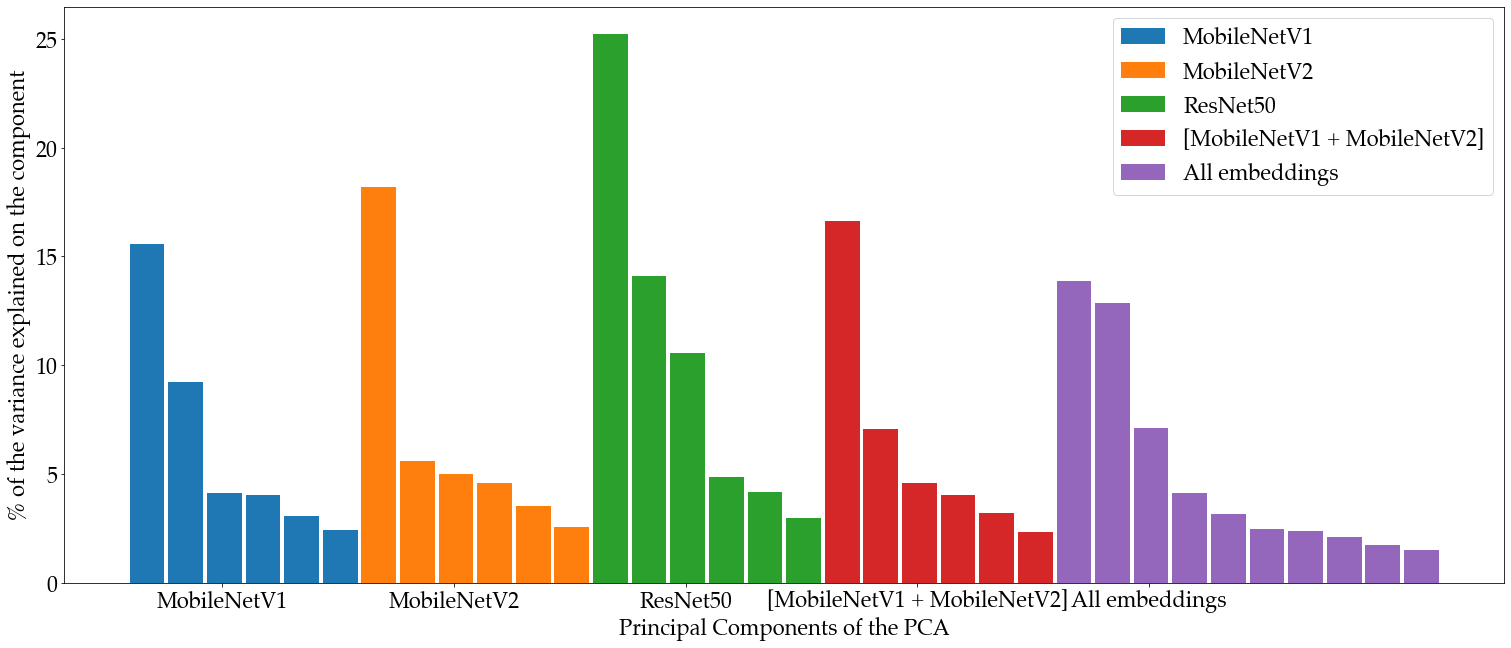

In [53]:
var= Figures.scree_plot(z_train, z_test, z_uncertain)

We compute the Shannon entropy using the 10 first eigen-values of the Principal Analysis decomposition.

In [55]:
import scipy
names = ["MobileNetV1", "MobileNetV2", "ResNet50", "MobileNetV1+MobileNetV2", "All embeddings concatenated"]
for i in range(len(var)):
    print(names[i], " : ", scipy.stats.entropy(var[i]))

MobileNetV1  :  1.9791071
MobileNetV2  :  1.9805077
ResNet50  :  1.8680859
MobileNetV1+MobileNetV2  :  1.9690129
All embeddings concatenated  :  1.9853019


**Observation**: The variance in the data is more or less distributed across the components:
- The variance is very concentrated on a single component for ResNet50
- In the opposite, the variance is more distributed across the components for MobileNetV1 and V2.
- Composing multiple embeddings do not increase the variance other components

The Shannon entropy on the 10 first eigen values of the PCA is a good indicator of the variance distribution among the components.
We might expect better separation between uncertain and certain data with ResNet50 since the variance is more distributed across several dimension.


We might expect better separation of the classes or the ambiguous or novel inputs with MobileNetV2 since the variance is more distributed across several dimension.

Let's vizualize the feature space for these two embeedings.

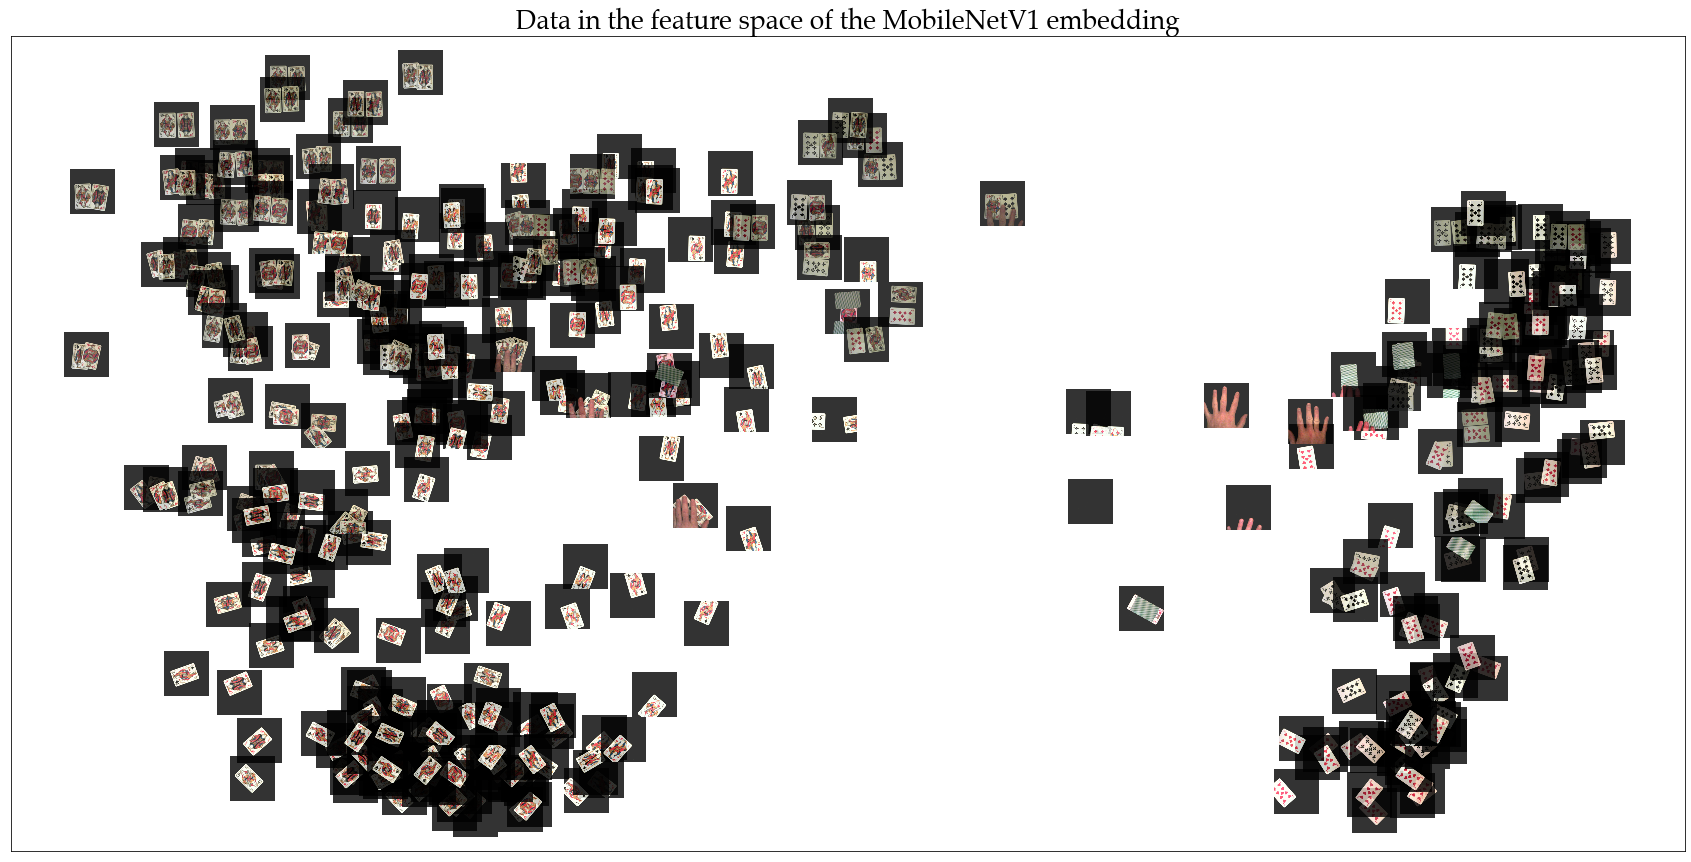

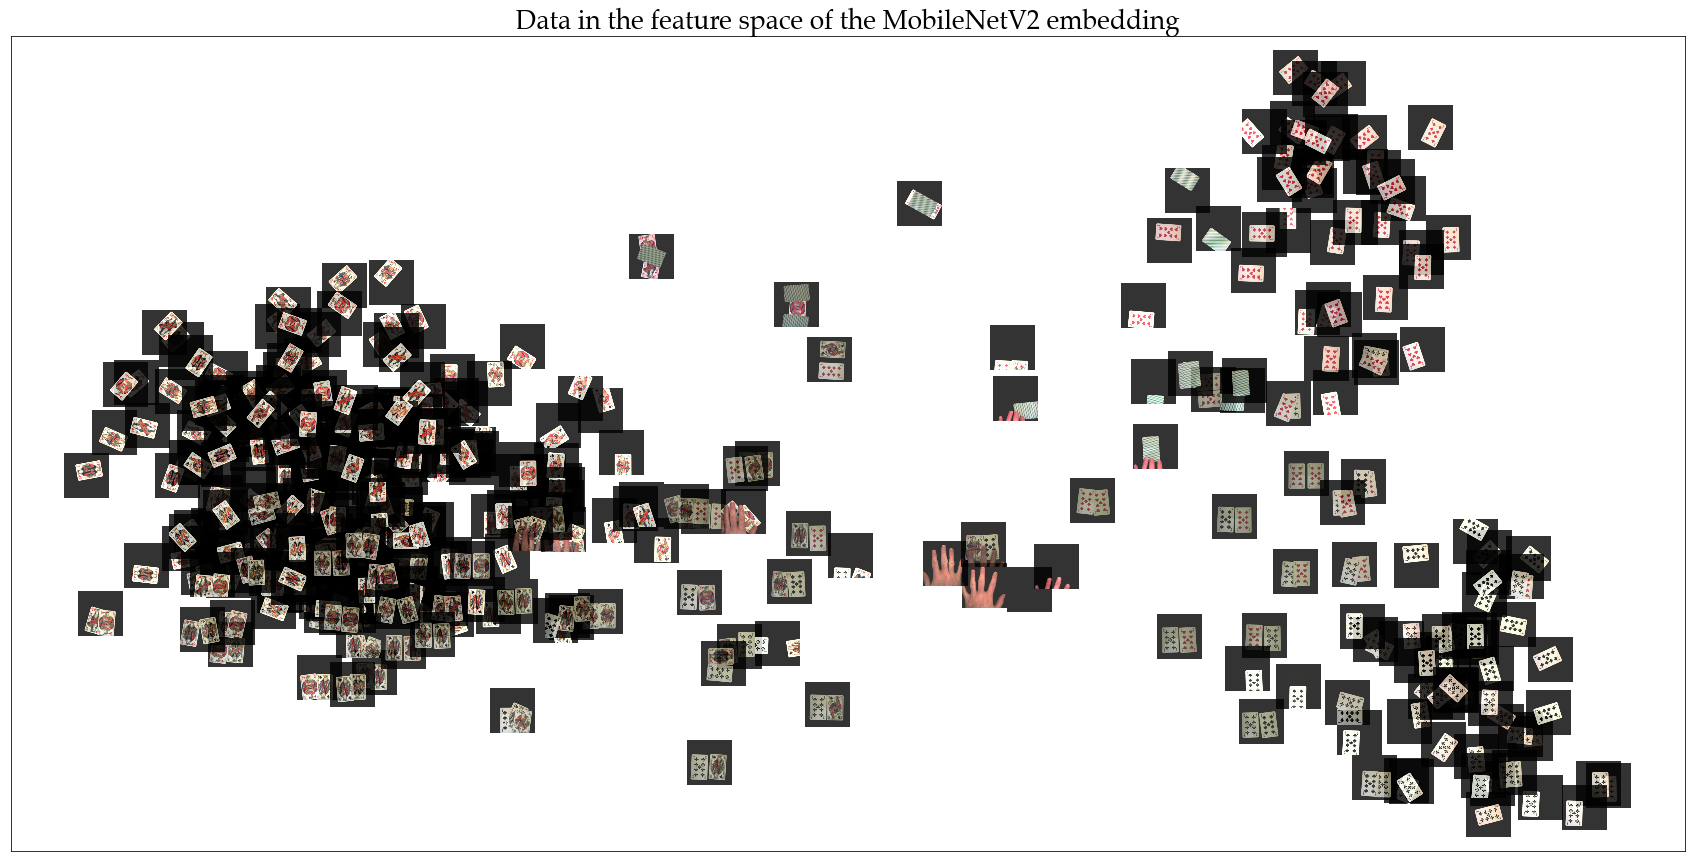

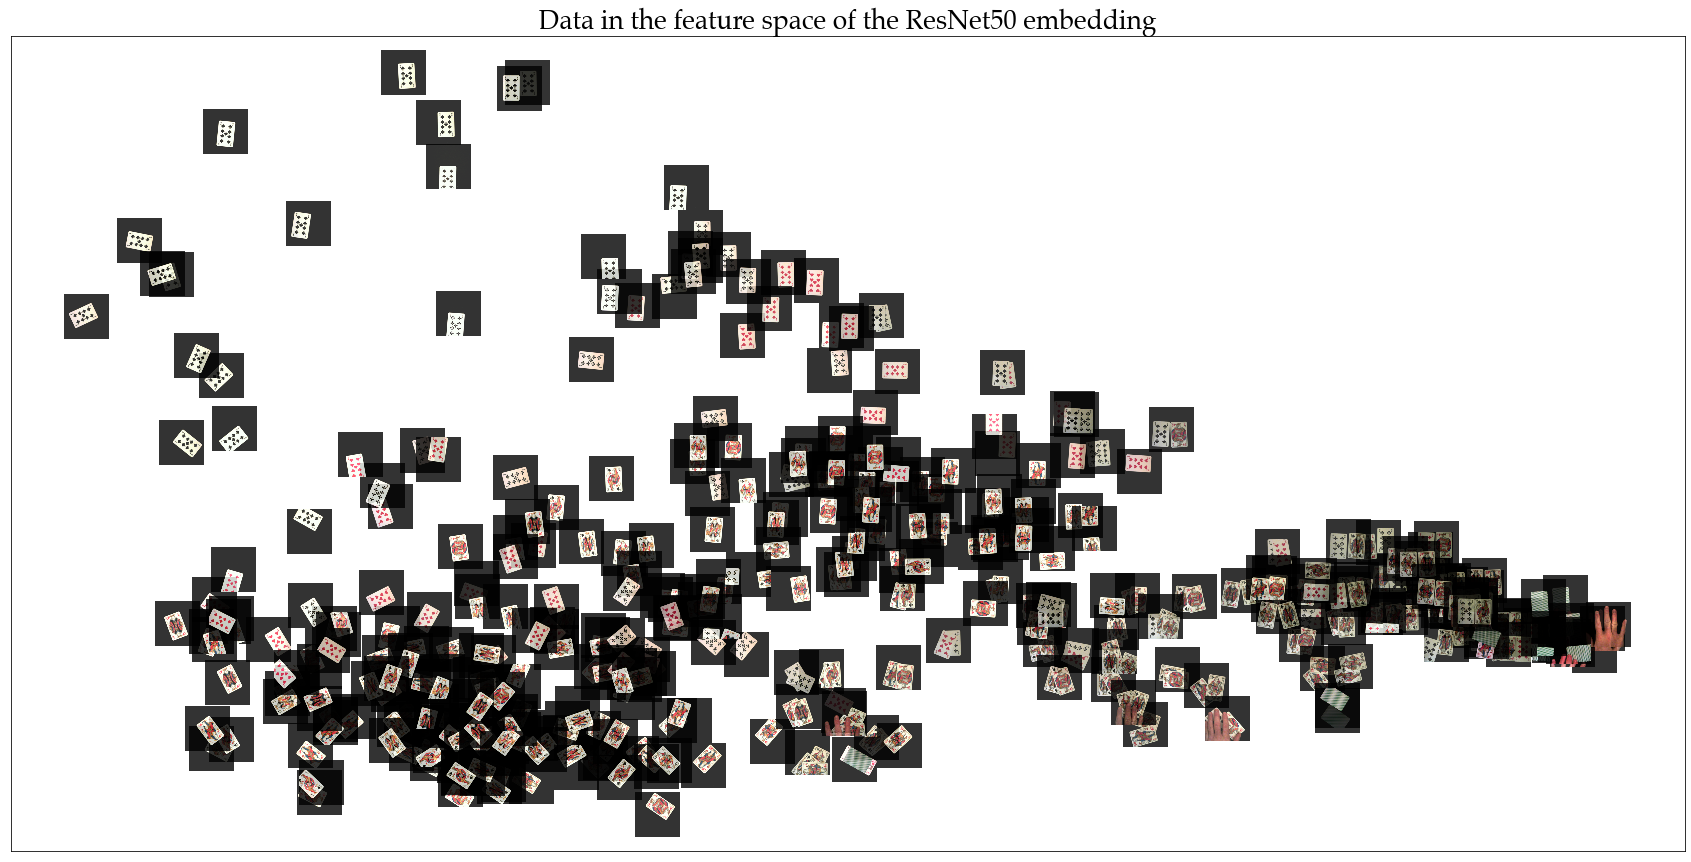

In [56]:
embeddings: dict = {0: "MobileNetV1", 1: "MobileNetV2", 2: "ResNet50", 3: "[MobileNetV1 + MobileNetV2]", 4: "All embeddings"}
z_all = np.concatenate((z_train, z_test, z_uncertain), axis = 0)
all_data = pd.concat([train, test, uncertain])
image_all = list(all_data["X_PIL"].values)
for i in [0,1,2]:
    z =Data.select_embedding(z_all, i)
    pca = PCA(n_components=10, svd_solver='full')
    z_all_2D = pca.fit(z).transform(z)
    plt.figure(figsize=(30,15))
    for j in range(len(image_all)):
        Figures.imscatter(z_all_2D[:,0][j], z_all_2D[:,1][j], image_all[j], ax=None, zoom=0.2)
        plt.title("Data in the feature space of the {0} embedding".format(embeddings[i]))

**Observations**: Visually, we observe a more coherent separation of the different types of card with the MobileNetV2 embedding and other cluster might exist in the remaining components. This confirms the intuition that we might expect a better separation of the data with MobileNetV2 embedding.

The introduction of the dataset, its collection, processing, annotation and visualization in different feature spaces is now over. Please go to the next notebook to learn about the uncertainty estimation used in the benchmark: [2_uncertainty_estimations.ipynb](./2_uncertainty_estimations.html) or return to the [index](./index.html)